# [Detekcja pojazdów](https://www.kaggle.com/datasets/ashfakyeafi/road-vehicle-images-dataset)
Użyteczne linki:  
[Exploring your image datasets the right way](https://raychunyin00.medium.com/computer-vision-exploring-your-image-datasets-the-right-way-538c5ae8ca5d)


# Opis problemu i danych
Problem - detekcja pojazdów na obrazie  
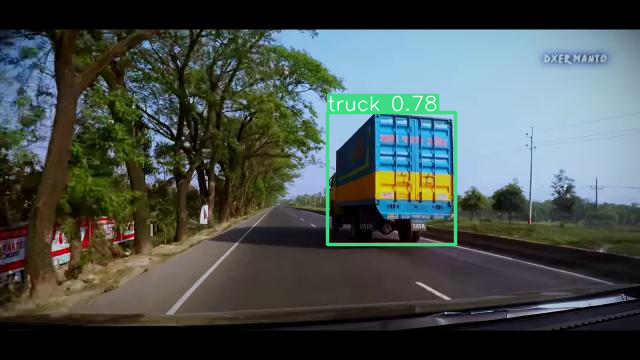

In [1]:
import os
import random

import cv2

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

c:\Users\juziu\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\juziu\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\juziu\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
train_images = "archive/trafic_data/train/images"
train_labels = "archive/trafic_data/train/labels"

## Wizualizacja danych treningowych - *zdjęć z labelami*

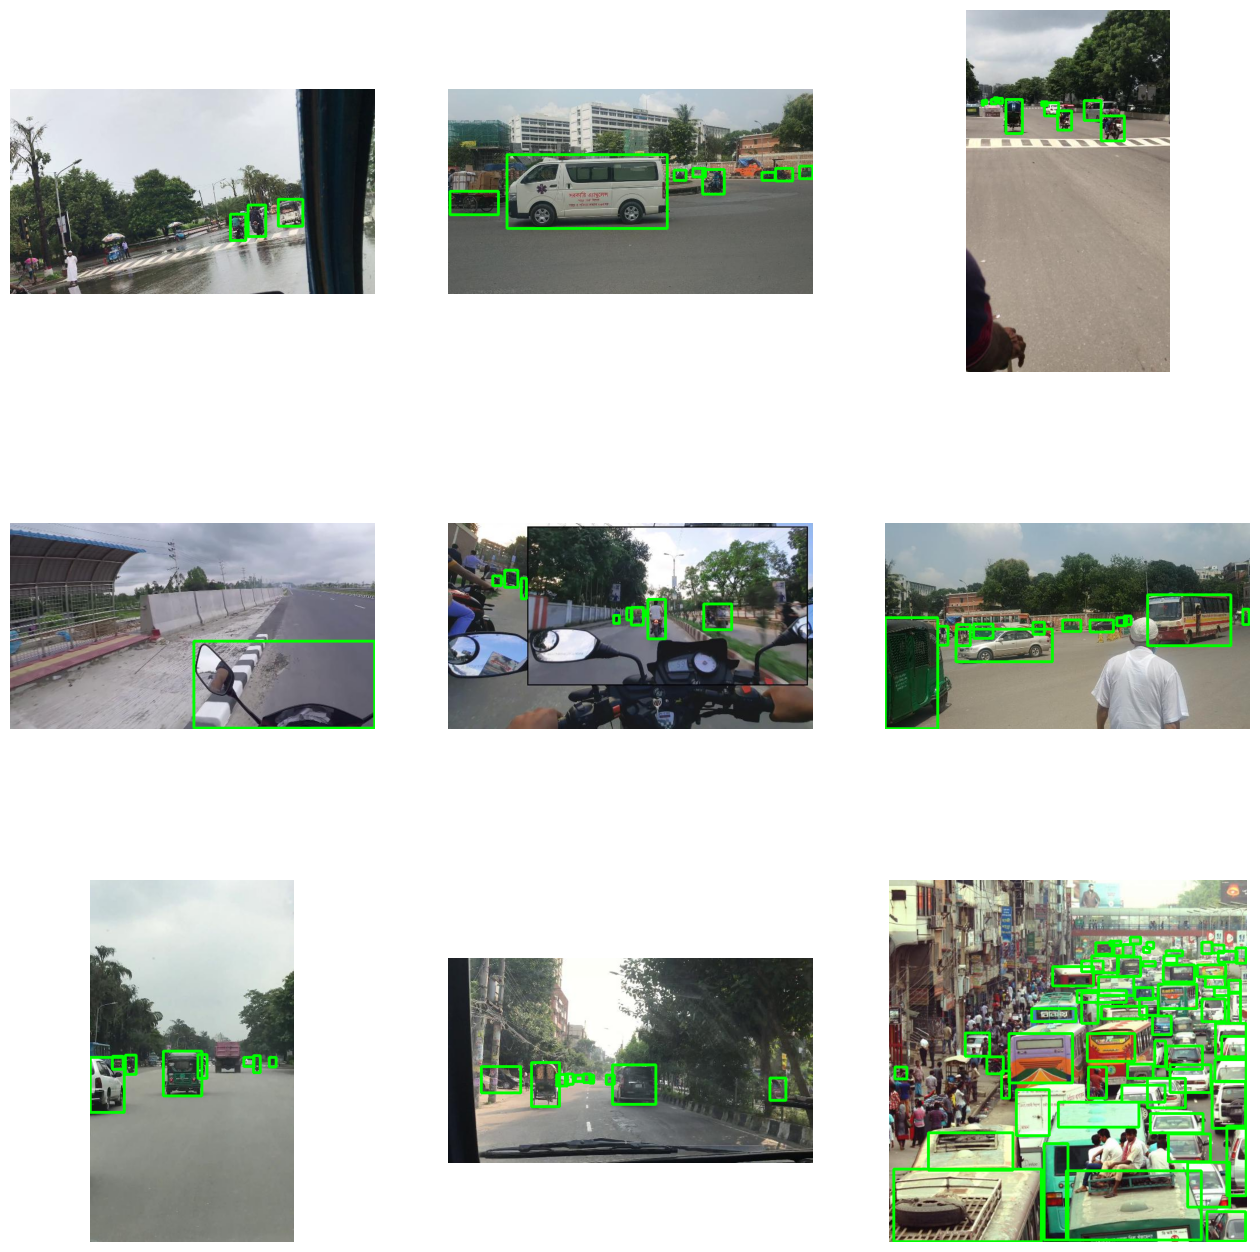

In [6]:
def load_labels(image_file, train_labels):
    label_file = os.path.splitext(image_file)[0] + ".txt"
    label_path = os.path.join(train_labels, label_file)
    
    with open(label_path, "r") as f:
        labels = f.read().strip().split("\n")
    
    return labels

def plot_object_detections(ax, image, labels):
    for label in labels:
        if len(label.split()) != 5:
            continue
        class_id, x_center, y_center, width, height = map(float, label.split())
        x_min = int((x_center - width/2) * image.shape[1])
        y_min = int((y_center - height/2) * image.shape[0])
        x_max = int((x_center + width/2) * image.shape[1])
        y_max = int((y_center + height/2) * image.shape[0])
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 3)

    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax.axis('off')

image_files = os.listdir(train_images)
random_images = random.sample(image_files, 9)

fig, axs = plt.subplots(3, 3, figsize=(16, 16))

for i, image_file in enumerate(random_images):
    row, col = divmod(i, 3)
    
    image_path = os.path.join(train_images, image_file)
    image = cv2.imread(image_path)

    labels = load_labels(image_file, train_labels)

    plot_object_detections(axs[row, col], image, labels)

plt.show()

In [8]:
with open('archive/trafic_data/data_1.yaml', 'r') as f:
    
    data = f.read()
    
print(data)

train: ../train/images
val: ../valid/images

nc: 21
names: ['ambulance', 'army vehicle', 'auto rickshaw', 'bicycle', 'bus', 'car', 'garbagevan', 'human hauler', 'minibus', 'minivan', 'motorbike', 'pickup', 'policecar', 'rickshaw', 'scooter', 'suv', 'taxi', 'three wheelers -CNG-', 'truck', 'van', 'wheelbarrow']


In [10]:
h, w, c = image.shape
print(f"The image has dimensions {w}x{h} and {c} channels.")

The image has dimensions 631x640 and 3 channels.


In [13]:
print(f"Długość zbioru: {len(image_files)}")

Długość zbioru: 2704


In [49]:
shapes_df = pd.DataFrame()
heights = []
widths = []
channels = []
for i, image_file in enumerate(image_files):
    image_path = os.path.join(train_images, image_file)
    image = cv2.imread(image_path)
    
    shape = image.shape
    heights.append(shape[0])
    widths.append(shape[1])
    channels.append(shape[2])

shapes_df['width'] = widths
shapes_df['height'] = heights
shapes_df['channel'] = channels
    

In [50]:
print(f"""Unique (Width, Height, Channel) values: {
    len(shapes_df['width'].unique()),
    len(shapes_df['height'].unique()),
    len(shapes_df['channel'].unique())
    }""")

Unique (Width, Height, Channel) values: (73, 200, 1)


In [51]:
print(f"""Unikalne kombinacje: {
    len(shapes_df[['width', 'height', 'channel']].drop_duplicates())
    }""")

Unikalne kombinacje: 270


In [72]:
shapes_df.value_counts()[:5]

width  height  channel
640    360     3          1510
360    640     3           274
480    640     3           138
640    359     3           132
       362     3            85
Name: count, dtype: int64

Widać, że najpopularniejsza kombinacja to 640x360 i vice versa.

FrozenList(['width', 'height', 'channel'])

In [90]:
# treating WxH as HxW
most_popular_shape = shapes_df.value_counts()[:2]
print(f"% zbioru jaki ma najpopularniejsza ({most_popular_shape[:1].index.names}) rozdzielczość: {most_popular_shape.sum()/len(shapes_df)*100:.2f} %")

% zbioru jaki ma najpopularniejsza (['width', 'height', 'channel']) rozdzielczość: 65.98 %


In [48]:
del shapes_df

## Podsumowanie sekcji
- 21 klas
- zbiór posiada 2704 obrazy
- istnieje wiele unikalnych wartości wysokości i szerokości obrazów, natomiast wartość kanałów jest jedna: 3 (RGB).
- unikalnych kombinacji tych trzech parametrów jest 270.  
- najpopularniejsza z nich (640x360 i odwrotnie) to około 66% całego zbioru. podczas transformacji warto będzie się przyglądnąć temu rozkładowi.

Oznacza to, że model albo musi być uniwersalny w przyjmowaniu rozmiarów wejściowych, albo obrazy należy zmodyfikować (a tym samym zmienić proporcje z np. 16:9 -> 1:1 {ustalona wielkość})  
Jedyne dane jakie posiadamy w tej chwili to dane zdjęcia, czyli zmienne traktowane ilościowo.  
  
Przeglądając te zdjęcia można zauważyć, że są one prawdopodobnie wyłącznie w jednym kraju, zapewne Azjatyckim. (Mój typ: Indie lub tajlandia).